
# ECMWF Open Data – Advanced Tutorial

This tutorial demonstrates how to retrieve and visualize data from ECMWF’s Open Data service using [EarthKit](https://earthkit.readthedocs.io/) and [ecmwf-opendata](https://github.com/ecmwf/ecmwf-opendata).

We will cover:
1. Data retrieval from **IFS‑single**, **IFS‑ENS**, **IFS waves** (deterministic & ensemble), and **AIFS‑single/AIFS‑ENS**
2. Visualization of retrieved parameters
3. EarthKit plotting capabilities
4. Derived calculations

### Map plotting with EarthKit Plots

In map cells we use **EarthKit Plots**: choose a **domain** (Natural Earth names), add **coastlines/gridlines**,
and optionally a background (`land()`, `ocean()`, or `stock_img()`). Filled fields use `contourf`, linework uses
`contour`, and vectors use `quiver` or `barbs`.

Docs: https://earthkit-plots.readthedocs.io/en/latest/


## ECMWF Open Data — quick facts & naming

This notebook uses **ECMWF Open Data** at **0.25°** (global) in **GRIB2**. Fields are redistributed from native model grids to a consistent open-data grid. We work with:

- **IFS-single**: deterministic IFS atmospheric output (often called “IFS‑single” elsewhere).
- **IFS-ENS**: IFS ensemble (control/perturbed, plus mean/std).
- **IFS waves**: wave model products (deterministic `wave` and ensemble `waef` streams).
- **AIFS-single / AIFS-ENS**: ECMWF’s AI-driven forecasts on the same 0.25° grid.

Each section explains *what is retrieved/plotted* and *what you can tweak* (parameters, steps, run time, styling).


## About ECMWF Open Data, resolution & naming

This notebook uses **ECMWF Open Data**, which provides **IFS** (Integrated Forecasting System) and **AIFS**
products on a **0.25° global grid** (about 28 km), delivered in **GRIB2**. This is a *regridded/open-data*
resolution compared to the native model grids.

**Naming used here**
- **IFS-single**: deterministic IFS (previously referred to as “IFS‑single” in many tools/examples).
- **IFS-ENS**: IFS ensemble (control/perturbed, ensemble mean/standard deviation).
- **AIFS**/**AIFS-ENS**: ECMWF’s AI-driven global forecasts (also distributed at 0.25° via open data).

**Docs**
- Open data access & coverage: https://www.ecmwf.int/en/forecasts/access-forecasts/access-real-time-open-data
- Product overview (0.25° grid): https://www.ecmwf.int/en/forecasts/datasets/open-data


# 1. Setup and Imports

This section sets up the environment and necessary libraries for accessing and processing ECMWF Open Data.

In [1]:
import os
import earthkit.data as ekd
import earthkit.plots as ekp
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Create data directory if not present
import os
os.makedirs("data", exist_ok=True)

### Determine latest model run

We use 12z if available (after 12:00 UTC), otherwise 00z from today or yesterday. This is important because the ECMWF Open Data archive only retains recent data (past 3 days).

In [2]:
now = datetime.utcnow()
if now.hour >= 12:
    model_run_hour = 12
    model_run_date = now
else:
    model_run_hour = 0
    model_run_date = now - timedelta(days=1)

fc_date = model_run_date.strftime("%Y%m%d")
fc_time = f"{model_run_hour:02}"
print(f"Using model run: {fc_date} at {fc_time}z")

Using model run: 20250821 at 00z



## 2. Accessing ECMWF Open Data

We demonstrate retrieval of 4 model types:

- **IFS‑single**: High-resolution deterministic model
- **ENS**: Ensemble prediction system (51 members)
- **AIFS**: AI-based deterministic model
- **AIFS-ENS**: AI-based ensemble

Each dataset is downloaded dynamically using `earthkit.data`.


### 2.1 Where is the data coming from?

ECMWF's open forecast data is hosted publicly at:

https://data.ecmwf.int/

No authentication or API key is needed.

EarthKit (`earthkit.data`) and the `ecmwf-opendata` Python client both retrieve forecast GRIB files by constructing URLs from this site.

### Directory structure

The URL structure follows this format:

https://data.ecmwf.int/forecasts/YYYYMMDD/HHz/{model}/{resolution}/{stream}/

- `YYYYMMDD` → Forecast date
- `HHz` → Model run time (00z or 12z)
- `model`:
  - `ifs` → Traditional IFS forecasts (IFS‑single, ENS)
  - `aifs-single` → AI deterministic
  - `aifs-ens` → AI ensemble
- `resolution`:  
  - `0p25`, `0p5`, or `1p0`
- `stream`:  
  - `oper` → IFS‑single / AIFS  
  - `enfo` → ENS / AIFS-ENS  
  - `waef`, `wave` → Wave forecasts

EarthKit and the `ecmwf-opendata` client automatically construct these URLs — but some custom tuning may be needed.

### Supported forecast models

| Model ID | Description              | Example Path                                      |
|----------|--------------------------|---------------------------------------------------|
| `ifs`    | IFS‑single and ENS             | `/ifs/0p25/oper/`, `/ifs/0p5/enfo/`               |
| `aifs-single` | AI deterministic       | `/aifs-single/0p25/oper/`                         |
| `aifs-ens` | AI ensemble              | `/aifs-ens/0p25/enfo/`                            |
| `ifs/wave` | Wave deterministic       | `/ifs/0p25/wave/`                                 |
| `ifs/waef` | Wave ensemble            | `/ifs/0p25/waef/`                                 |


### 2.2 Understanding Keywords and API Parameters

The `ecmwf-open-data` source requires specifying model parameters correctly. Common use cases are using:

- `model`: `"hres"`, `"ens"`, `"aifs"`, `"aifs-ens"`
- `stream`: Commonly `"oper"`for forecast data or `"enfo"` for ensable forecast data
- `type`: `"fc"` (forecast), `"cf"` (control forecast)
- `step`: Forecast step (e.g. `00`, `06`, `12` etc)
- `time`: Model run time (e.g. `00` or `12` UTC etc)
- `param`: Parameters like `"msl"`, `"u10"`, `"v10"`, `"2t"`, `"t@850"`, etc. Note that these can vary depending on the model.

More info:
- [EarthKit source docs](https://earthkit-data.readthedocs.io/en/latest/guide/sources.html#ecmwf-open-data)
- [ecmwf-opendata GitHub](https://github.com/ecmwf/ecmwf-opendata)


In [3]:
# needs markdown to explain time placeholder

from datetime import datetime, timedelta
from ecmwf.opendata import Client
import os

# Ensure output folder exists
os.makedirs("data", exist_ok=True)

# Use yesterday's 12z model run (safe default for open data)
model_run_date = datetime.utcnow() - timedelta(days=1)
fc_date = model_run_date.strftime("%Y%m%d")
fc_time = 12  # fixed 12z

print(f"Using model run: {fc_date} at {fc_time}z")


Using model run: 20250821 at 12z


## Data retrieval overview

In the next cells we **download data** from ECMWF Open Data catolg using the lightweight **ecmwf-opendata** client and then **load** the GRIB files with **EarthKit Data** (`earthkit.data`).

- You can **omit** `date`/`time` to pull the **latest available run**, or set them explicitly (e.g. `date='YYYYMMDD'`, `time=0/12`).
- Use **lists** for `param` (e.g. `['2t','10u','10v']`) and **ranges** for `step` (e.g. `range(0,25,3)`).
- `levtype='sfc'` gives surface/single-level fields; `levtype='pl'` needs a `levelist` (e.g. `1000/925/850/...`).

More info: [EarthKit Data docs](https://earthkit.readthedocs.io/en/latest/) • [ECMWF Open Data](https://github.com/ecmwf/ecmwf-opendata)


### Retrieve **IFS-single (deterministic model) data**

We request **"msl/2t/10u/10v"** over **0** from `"oper"/"fc"` (levtype='sfc'). The client writes **GRIB2** to `data/hres_msl_2t_10uv.grib2` for **the specified run**.

**You can tweak:** `param` (variables), `step` (horizon/resolution), `date/time` (specific run).

In [4]:
# IFS Deterministic (HRES) — MSLP, 2 m Temperature, 10 m Winds

client = Client(source="ecmwf")

client.retrieve(
    model="ifs",
    stream="oper",
    type="fc",
    time=fc_time,
    date=fc_date,
    step=0,
    param="msl/2t/10u/10v",
    target="data/hres_msl_2t_10uv.grib2"
)

20250821120000-0h-oper-fc.grib2:   0%|          | 0.00/2.55M [00:00<?, ?B/s]

### Retrieve **IFS-ENS model data** (control forecast)

We request **"msl/2t/10u/10v"** over **0** from `"enfo"/"cf"` (levtype='"sfc"'). The client writes **GRIB2** to `data/ens_cf_2t_10uv.grib2` for **the specified run**.

**You can tweak:** `param` (variables), `step` (horizon/resolution), `date/time` (specific run).

In [5]:
# IFS Ensemble Control (ENS CF) — 2 m T + 10 m Winds

client = Client(source="ecmwf")

client.retrieve(
    model="ifs",
    stream="enfo",
    type="cf",             # control forecast
    time=fc_time,
    date=fc_date,
    step=0,
    levtype="sfc",
    param="msl/2t/10u/10v",
    target="data/ens_cf_2t_10uv.grib2",
)

20250821120000-0h-enfo-ef.grib2:   0%|          | 0.00/2.55M [00:00<?, ?B/s]

### Retrieve **IFS-ENS model data** (ensamble mean)

We request **"t"** over **0** from `"enfo"/"em"` (levtype='"pl"', levelist=850). The client writes **GRIB2** to `data/ens_em_t850.grib2` for **the specified run**.

**You can tweak:** `param` (variables), `step` (horizon/resolution), `date/time` (specific run).

In [6]:
# IFS Ensemble Mean (ENS EM) — T@850 hPa + MSLP 

client = Client(source="ecmwf")

client.retrieve(
    model="ifs",
    stream="enfo",
    type="em",             # ensemble mean
    time=fc_time,
    date=fc_date,
    step=0,
    levtype="pl",
    levelist=850,
    param="t",
    target="data/ens_em_t850.grib2",
)

# Optional: adding surface MSLP from Ensamble Mean in the same time to co-plot with t850
client.retrieve(
    model="ifs",
    stream="enfo",
    type="em",
    time=fc_time,
    date=fc_date,
    step=0,
    levtype="sfc",
    param="msl",
    target="data/ens_em_msl.grib2",
)

20250821120000-240h-enfo-ep.grib2:   0%|          | 0.00/607k [00:00<?, ?B/s]

20250821120000-240h-enfo-ep.grib2:   0%|          | 0.00/517k [00:00<?, ?B/s]

### Retrieve **IFS wave (deterministic) model data**

We request **"swh/mwp/mwd"** over **0** from `"wave"/"fc"` (levtype='sfc'). The client writes **GRIB2** to `data/wave_deterministic_swh_mwp_mwd.grib2` for **the specified run**.

**You can tweak:** `param` (variables), `step` (horizon/resolution), `date/time` (specific run).

In [7]:
# Wave Model Deterministic (HRES-WAM) — swh, mwp, mwd
client = Client(source="ecmwf")
client.retrieve(
    model="ifs",
    stream="wave",
    type="fc",
    time=fc_time,
    date=fc_date,
    step=0,
    param="swh/mwp/mwd",   # added mwd
    target="data/wave_deterministic_swh_mwp_mwd.grib2",
)

20250821120000-0h-wave-fc.grib2:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

### Retrieve **IFS waves (ENS) model data** (control forecast) 

We request **"swh/mwp/mwd"** over **0** from `"waef"/"cf"` (levtype='sfc').
The client writes **GRIB2** to `data/wave_ensemble_cf_swh_mwp_mwd.grib2` for **the specified run**.

**You can tweak:** `param` (variables), `step` (horizon/resolution), `date/time` (specific run).

In [8]:
# Wave Model Ensemble (ENS-WAM, WAEF) — control, swh, mwp, mwd
client = Client(source="ecmwf")
client.retrieve(
    model="ifs",
    stream="waef",
    type="cf",
    time=fc_time,
    date=fc_date,
    step=0,
    param="swh/mwp/mwd",   # added mwd
    target="data/wave_ensemble_cf_swh_mwp_mwd.grib2",
)

20250821120000-0h-waef-ef.grib2:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

### Retrieve **AIFS-single model data**

We request **"msl/2t"** over **0** from `"oper"/"fc"` (levtype='"sfc"'). The client writes **GRIB2** to `data/aifs_det_msl_2t.grib2` for **the specified run**.

**You can tweak:** `param` (variables), `step` (horizon/resolution), `date/time` (specific run).

In [9]:
# AIFS Deterministic (Single) — MSLP + 2m Temp

client = Client(source="ecmwf", model="aifs-single")

client.retrieve(
    stream="oper",
    type="fc",
    time=fc_time,
    date=fc_date,
    step=0,
    levtype="sfc",
    param="msl/2t",
    target="data/aifs_det_msl_2t.grib2",
)

20250821120000-0h-oper-fc.grib2:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

### Retrieve **AIFS-ENS model data** (control forecast)

We request **"2t/10u/10v"** over **0** from `"enfo"/"cf"` (levtype='"sfc"'). The client writes **GRIB2** to `data/aifs_ens_cf_2t_10uv.grib2` for **the specified run**.

**You can tweak:** `param` (variables), `step` (horizon/resolution), `date/time` (specific run).

In [10]:
# AIFS Ensemble — 2 m T + 10 m Winds, Control

client = Client(source="ecmwf", model="aifs-ens")

client.retrieve(
    stream="enfo",
    type="cf",             # control forecast
    time=fc_time,
    date=fc_date,
    step=0,
    levtype="sfc",
    param="2t/10u/10v",
    target="data/aifs_ens_cf_2t_10uv.grib2",
)

20250821120000-0h-enfo-cf.grib2:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

### 3. Processing and plotting

Before starting with data plotting, we first need to load and filter data fields, which we do in the following cell.

In [11]:
# Load GRIB files for plotting
import earthkit.data as ekd

# IFS HRES deterministic (surface bundle: msl, 2t, 10u, 10v)
hres_sfc = ekd.from_source("file", "data/hres_msl_2t_10uv.grib2")

# IFS ENS control (surface: 2t, 10u, 10v)
ens_cf_sfc = ekd.from_source("file", "data/ens_cf_2t_10uv.grib2")

# IFS ENS mean (T@850 hPa) and optional EM MSLP
ens_em_tpl = ekd.from_source("file", "data/ens_em_t850.grib2")
ens_em_msl = ekd.from_source("file", "data/ens_em_msl.grib2")  # if you retrieved it

# AIFS deterministic (msl, 2t)
aifs_det = ekd.from_source("file", "data/aifs_det_msl_2t.grib2")

# AIFS ensemble control (2t, 10u, 10v)
aifs_ens_cf = ekd.from_source("file", "data/aifs_ens_cf_2t_10uv.grib2")

# Waves: deterministic and ensemble control with swh/mwp/mwd
wave_det = ekd.from_source("file", "data/wave_deterministic_swh_mwp_mwd.grib2")
wave_ens_cf = ekd.from_source("file", "data/wave_ensemble_cf_swh_mwp_mwd.grib2")

### 3.2 Plotting the Retrieved Data

We now visualize the fields retrieved from each of the six models. We'll use `earthkit.plots` for plotting.

*More info:* [EarthKit Plots](https://earthkit-plots.readthedocs.io/en/latest/),
[Nautral Earth](https://www.naturalearthdata.com/)

### Plot **2 m Temperature (°C) with MSLP isolines** — IFS-single (detrministic)

We shade 2 m temperature (K→°C at plot time) and overlay MSLP in black contours. **Domain:** `"global"` (using Natural Earth regions).

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...
ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


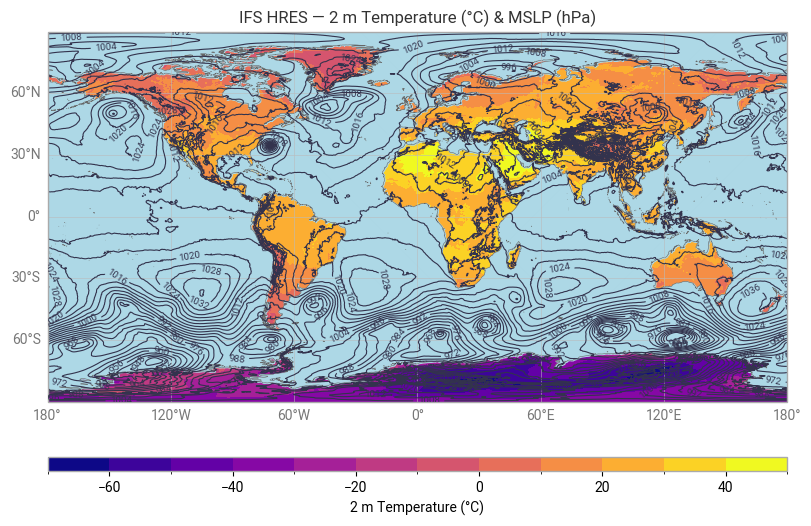

In [12]:
import earthkit.plots as ekp

t2m = hres_sfc.sel(shortName="2t")[0]
msl = hres_sfc.sel(shortName="msl")[0]

chart = ekp.Map(domain="global")

t_style = ekp.styles.Style(units="celsius")
chart.contourf(t2m, style=t_style)

t_layer = chart.layers[-1]

chart.land(color="lightgreen")
chart.ocean(color="lightblue")
chart.coastlines(color="0.4", linewidth=0.4)
chart.gridlines()
chart.contour(msl, units="hPa", auto_style=True, linewidths=0.8)

fig = chart.ax.figure
cb = fig.colorbar(
    t_layer.mappable, ax=chart.ax,
    orientation="horizontal",
    aspect=50 
)
cb.set_label("2 m Temperature (°C)")

chart.title("IFS HRES — 2 m Temperature (°C) & MSLP (hPa)")
chart.show()

### Plot **2 m Temperature (°C) with MSLP isolines** — IFS-ENS (control forecast)

We shade 2 m temperature (K→°C at plot time) and overlay MSLP in black contours. 

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...
ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


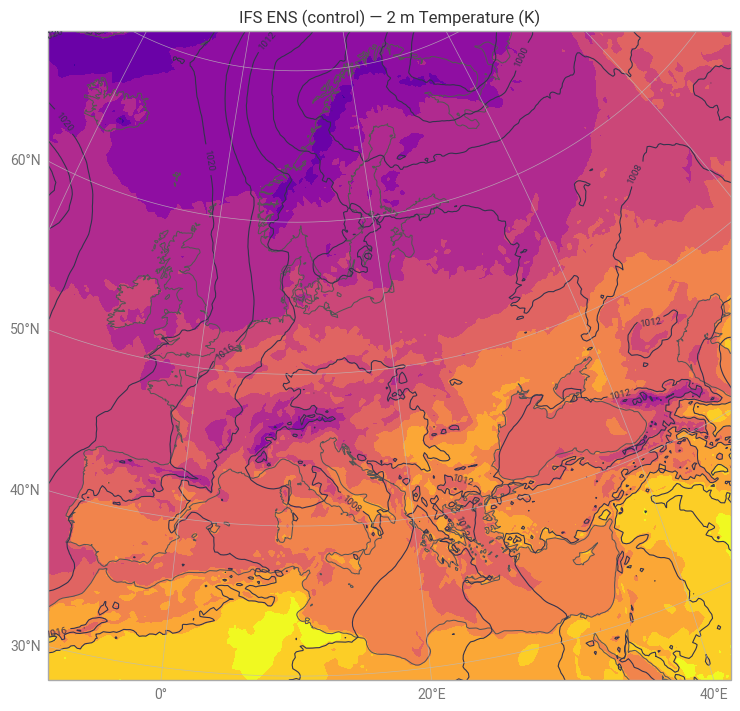

In [13]:
# ENS Control — 2 m Temperature (filled)
import earthkit.plots as ekp

t2m_cf = ens_cf_sfc.sel(shortName="2t")[0]
msl = ens_cf_sfc.sel(shortName="msl")[0]


chart = ekp.Map(domain="Europe")
chart.contourf(t2m_cf, style=ekp.styles.Style(units="K"))
chart.contour(msl, units="hPa", auto_style=True, linewidths=0.8)

chart.coastlines()
chart.gridlines()
chart.title("IFS ENS (control) — 2 m Temperature (K)")
chart.show()

### Plot **Temperature @850 hPa height (K)** — IFS-ENS (ensemble mean)

Render a gridded field on a regional map using **Domain:** `"Europe"`.

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...
ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


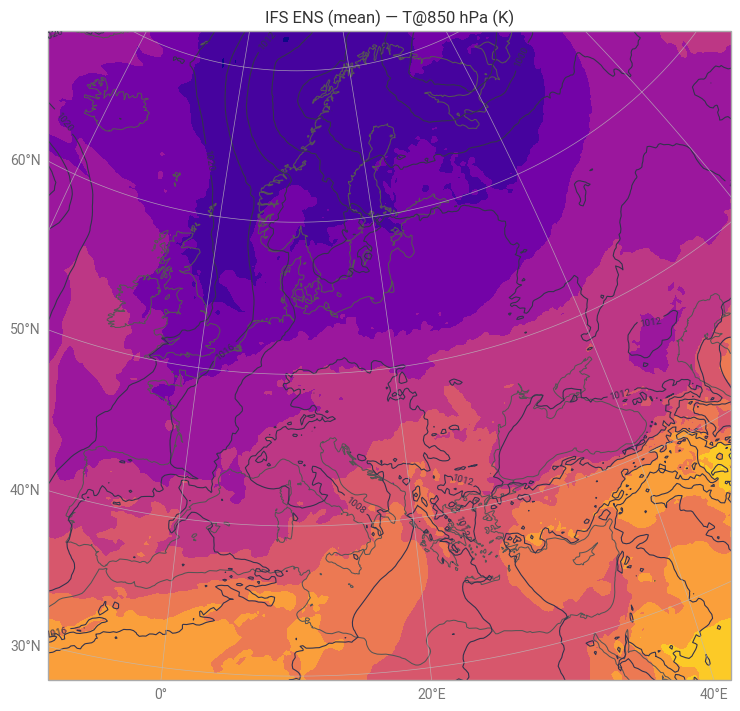

In [14]:
# ENS Mean — T@850 hPa (filled) + optional MSLP (contours)
import earthkit.plots as ekp

t850_em = ens_em_tpl.sel(shortName="t", level=850)[0]
msl = ens_em_msl.sel(shortName="msl")[0]


chart = ekp.Map(domain="Europe")
chart.contourf(t850_em, style=ekp.styles.Style(units="K"))
chart.contour(msl, units="hPa", auto_style=True, linewidths=0.8)

chart.coastlines()
chart.gridlines()
chart.title("IFS ENS (mean) — T@850 hPa (K)" )
chart.show()

### In the next cell: plot **2 m Temperature (°C) with MSLP isolines** — AIFS-single

We shade 2 m temperature (converted from Kelvin to Celsius using EarthKit) and overlay MSLP in black contours. 


ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


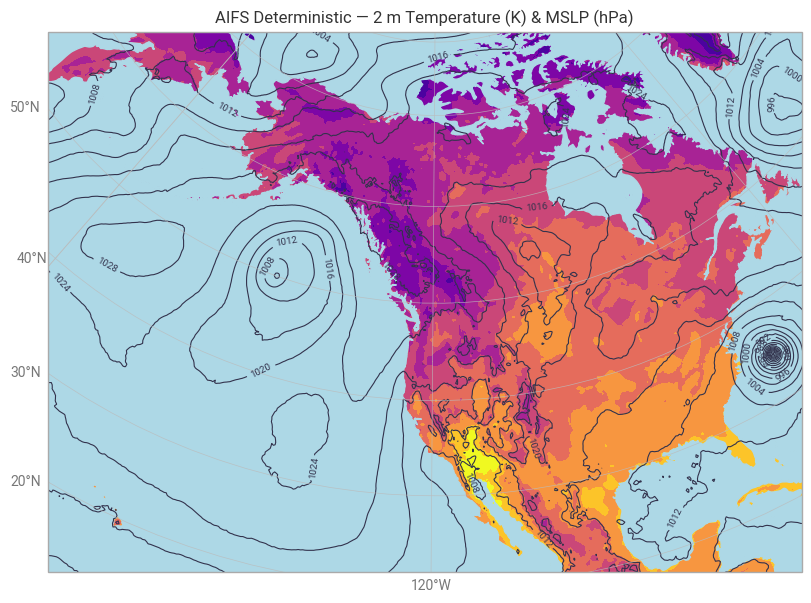

In [15]:
# AIFS Deterministic — 2 m Temperature (filled) + MSLP (contours)
import earthkit.plots as ekp

t2m_a = aifs_det.sel(shortName="2t")[0]
msl_a = aifs_det.sel(shortName="msl")[0]

chart = ekp.Map(domain="USA")
chart.contourf(t2m_a, style=ekp.styles.Style(units="celsius"))
chart.contour(msl, units="hPa", auto_style=True, linewidths=0.8)

chart.ocean(color="lightblue")


chart.gridlines()
chart.title("AIFS Deterministic — 2 m Temperature (K) & MSLP (hPa)")
chart.show()

### Plot **2 m Temperature (K)** — AIFS-ENS

Here we create a plot using AIFS ENS control forecast data.

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


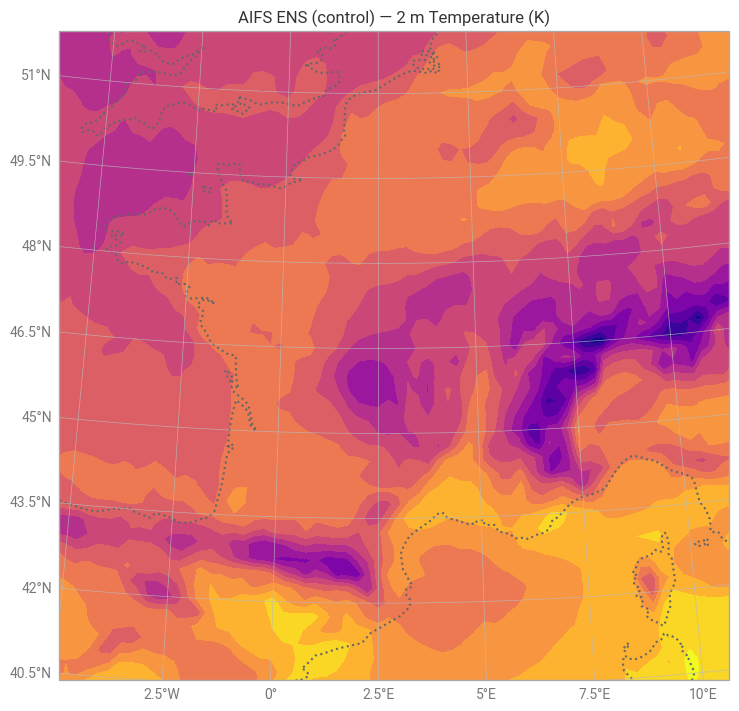

In [16]:
# AIFS ENS Control — 2 m Temperature (K) 
import earthkit.plots as ekp

t2m_ae = aifs_ens_cf.sel(shortName="2t")[0]

chart = ekp.Map(domain="France")
chart.contourf(t2m_ae, style=ekp.styles.Style(units="K"))

chart.coastlines(color="0.4", linewidth=1.5, linestyle=":") 
chart.gridlines()
chart.title("AIFS ENS (control) — 2 m Temperature (K)")
chart.show()

### Plot **Global waves: SWH (filled) + MWP contours** — IFS waves (deterministic)

In next plot we shows SWH magnitude; while MWP adds context with thin isolines over terrain/sea background. 

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...
ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


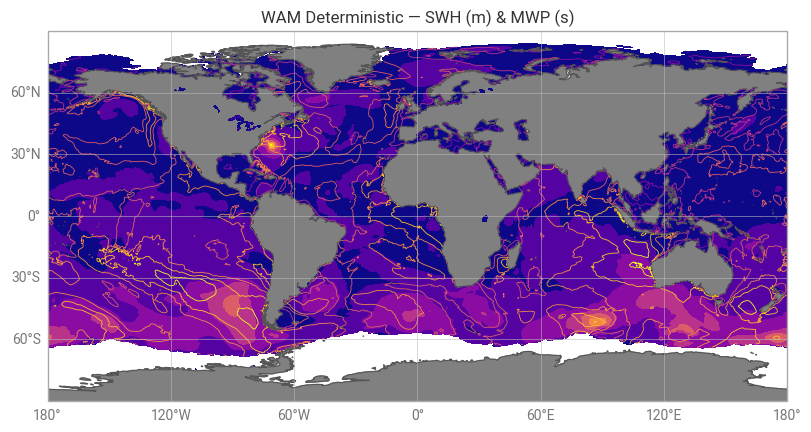

In [17]:
# Wave Model Deterministic — SWH (filled) + MWP (contours)
import earthkit.plots as ekp

swh = wave_det.sel(shortName="swh")[0]
mwp = wave_det.sel(shortName="mwp")[0]

chart = ekp.Map(domain="global")

# chart.stock_img()
chart.land(color="gray")

# waves on top
chart.contourf(swh, style=ekp.styles.Style(units="m"))        # significant wave height
chart.contour(mwp, units="s", auto_style=True, linewidths=0.6) # mean wave period

chart.coastlines()
chart.gridlines()
chart.title("WAM Deterministic — SWH (m) & MWP (s)")
chart.show()

### Plot **Global waves: SWH (filled) + MWP contours** — IFS waves (ENS)

We plot SWH showing wave height magnitude; with MWP adding context using thin isolines.

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...
ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


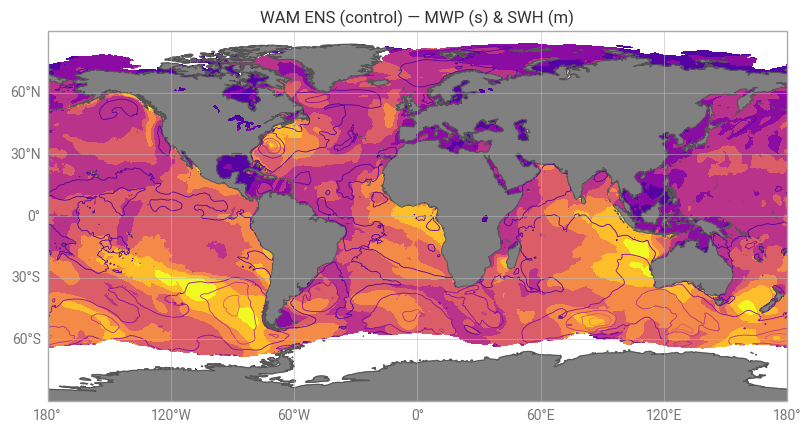

In [18]:
# Wave Model ENS Control — MWP (filled) + SWH (contours)
import earthkit.plots as ekp

mwp_cf = wave_ens_cf.sel(shortName="mwp")[0]
swh_cf = wave_ens_cf.sel(shortName="swh")[0]

chart = ekp.Map(domain="global")

# chart.stock_img()

# waves on top
chart.contourf(mwp_cf, style=ekp.styles.Style(units="s"))
chart.contour(swh_cf, units="m", linewidths=0.6, auto_style=True)

chart.coastlines()
chart.land(color="gray")
chart.gridlines()
chart.title("WAM ENS (control) — MWP (s) & SWH (m)")
chart.show()

### 3.1 Other plot types: wind vectors & barbs

### Wind Vectors with EarthKit

Next we demonstrate two different ways to visualize wind using EarthKit’s plotting API:

1. **Basic wind barbs**, useful for directional vector display.
2. **Styled wind quiver plot**, where arrow color represents wind speed.

These plots are created using the `Map` chart type and built-in `.barbs()` or `.quiver()` methods from EarthKit. Similar approach can also be used to plot other directional vector data.

### Wind barbs (10 m) — IFS-single

First we plot simple **10 m wind barbs** from IFS-single data.

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...
ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


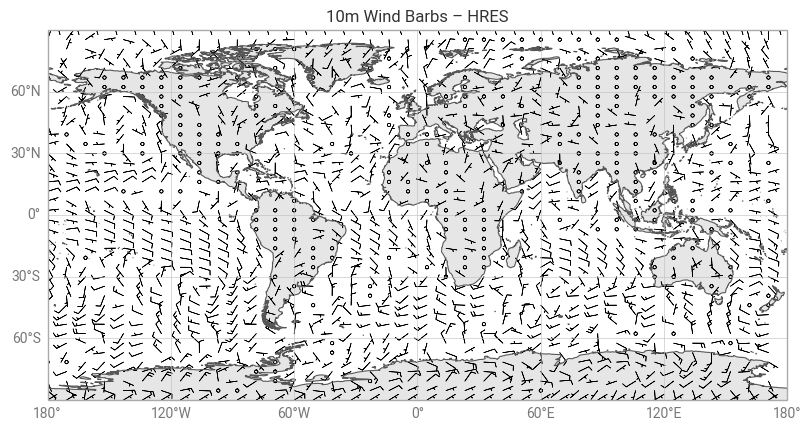

In [19]:
import earthkit.data as ekd
import earthkit.plots as ekp

# Load u10 and v10 wind components
ds = ekd.from_source("file", "data/hres_msl_2t_10uv.grib2")
chart = ekp.Map(domain="Africa")

u10 = ds.sel(shortName="10u")[0]
v10 = ds.sel(shortName="10v")[0]

# Create chart
chart = ekp.Map(domain="global")

# Add wind barbs (default style)
chart.barbs(u10, v10)
chart.land(color="0.9") 
chart.coastlines()
chart.gridlines()
chart.title("10m Wind Barbs – HRES")
chart.show()

### Wind vectors (quiver) — IFS-single

Now we showcase plotting of **10 m wind arrows** and **colour them by speed** using the quiver layer’s mappable. We thin the vectors
with `Subsample(...)` for readability and clamp the colour scale to robust percentiles to avoid outliers dominating.


ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...
ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


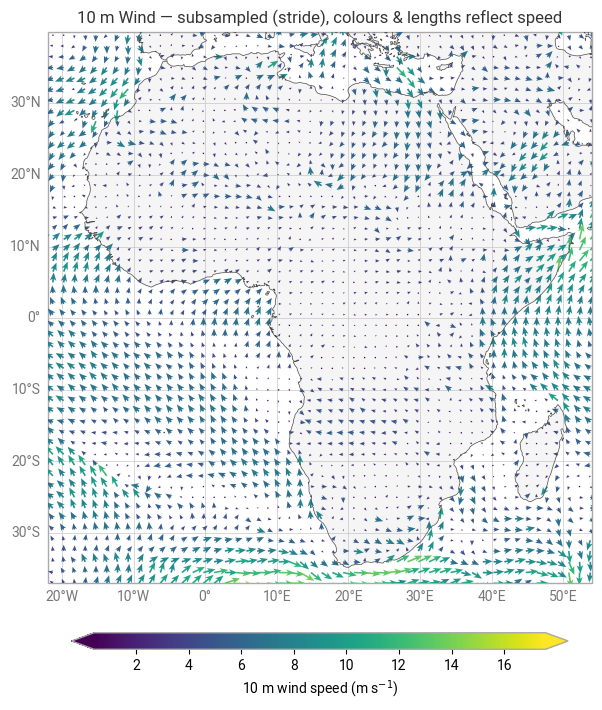

In [20]:
import numpy as np
import earthkit.data as ekd
import earthkit.plots as ekp
from earthkit.plots.resample import Subsample

# Data
ds  = ekd.from_source("file", "data/hres_msl_2t_10uv.grib2")
u10 = ds.sel(shortName="10u")[0]
v10 = ds.sel(shortName="10v")[0]

# Robust colour limits from full-field speed
speed = np.hypot(u10.to_numpy(), v10.to_numpy())
vmin, vmax = np.nanpercentile(speed, [1, 99])

# Map
chart = ekp.Map(domain="Africa")
chart.land(color="0.96")

# Quiver: colour by |(u,v)|, stride-subsampled
chart.quiver(
    u=u10, v=v10,
    colors=True,                                # colours = speed magnitude
    resample=Subsample(nx=6, ny=6, mode="stride"),
    cmap="cividis",
    scale=6,                                    # smaller -> longer arrows (tune 4–10)
    width=0.003, headwidth=4.0, headlength=5.0, headaxislength=4.0,
    zorder=5
)

# Clamp colours to chosen range + matching horizontal colorbar
q_layer = chart.layers[-1]
q_layer.mappable.set_clim(vmin, vmax)
cb = chart.ax.figure.colorbar(
    q_layer.mappable, ax=chart.ax,
    orientation="horizontal", pad=0.05, fraction=0.03, aspect=30,
    extend="both"
)
cb.set_label("10 m wind speed (m s$^{-1}$)")

chart.coastlines(color="0.3", linewidth=0.5, zorder=6)
chart.gridlines(zorder=6)
chart.title("10 m Wind — subsampled (stride), colours & lengths reflect speed")
chart.show()

### Point time series 
#### Retrieval of IFS-single (2 m temperature)

To showcase time-series plots we first need to data covering multiple time-steps. Here we download **IFS-single** surface field **`2t`** for multiple forecast steps (e.g., `0..24 by 3 h`) and store it into a single GRIB2 file.

**Note:** you can edit`param` (variables), `step` (horizon/resolution), `date/time` (specific run).


In [21]:
from ecmwf.opendata import Client
import earthkit.data as ekd

# Valid HRES steps (sample): 0..24 by 3 h
steps = list(range(0, 25, 3))  # [0, 3, 6, 9, 12, 15, 18, 21, 24]

client = Client(source="ecmwf")
result = client.retrieve(
    model="ifs",
    stream="oper",
    type="fc",
    step=steps,                # multi-step
    levtype="sfc",
    param="2t",                # one param for your time series
    target="data/hres_ts_2t.grib2",
)

print("Retrieved run:", result.datetime, "| steps:", steps)

# Load the multi-step file for plotting
hres_ts = ekd.from_source("file", "data/hres_ts_2t.grib2")

<multiple>:   0%|          | 0.00/5.68M [00:00<?, ?B/s]

Retrieved run: 2025-08-22 00:00:00 | steps: [0, 3, 6, 9, 12, 15, 18, 21, 24]


### Point time series — plot (IFS-single, 2 m temperature)

Now we extract the nearest grid point for a given location (lon/lat), convert **K → °C** for display and create a simple line plot. The x‑axis shows forecast step.


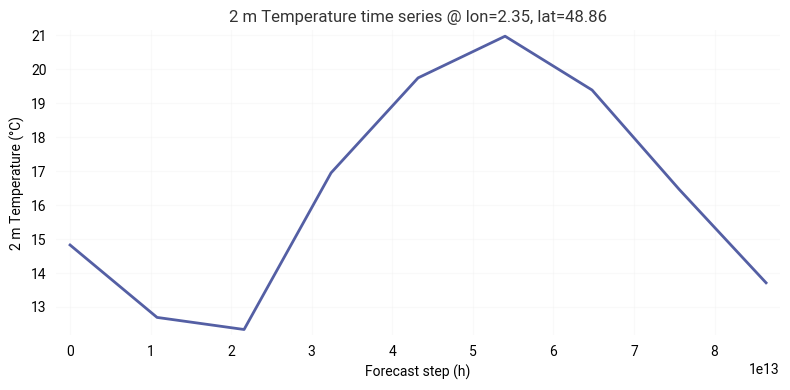

In [22]:
# Time series of 2 m temperature at a point (°C) from the multi-step GRIB
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Choose a location (lon, lat)
lon, lat = 2.35, 48.86  # Paris (change as needed)

# 1) Get 2t as an xarray object, normalize to a DataArray
xa = hres_ts.sel(shortName="2t").to_xarray()
if isinstance(xa, xr.Dataset):
    # one var -> take it; else stack to a single DataArray
    da_2t = xa[list(xa.data_vars)[0]] if len(xa.data_vars) == 1 else xa.to_array().squeeze(drop=True)
else:
    da_2t = xa  # already a DataArray

# 2) Coordinate names can vary; pick what's present
lon_name = "longitude" if "longitude" in da_2t.coords else ("lon" if "lon" in da_2t.coords else list(da_2t.coords)[-1])
lat_name = "latitude"  if "latitude"  in da_2t.coords else ("lat" if "lat" in da_2t.coords else list(da_2t.coords)[-2])

# 3) Nearest grid point through all steps
pt = da_2t.sel({lon_name: lon, lat_name: lat}, method="nearest")

# 4) X-axis: use 'step' if present
if "step" in pt.dims or "step" in pt.coords:
    x = (pt["step"].values if "step" in pt.coords else pt.coords["step"].values)
    x_label = "Forecast step (h)"
else:
    x = np.arange(pt.size)
    x_label = "Index"

# 5) K → °C and plot
t2m_c = pt.values - 273.15

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, t2m_c, linewidth=2)
ax.set_xlabel(x_label)
ax.set_ylabel("2 m Temperature (°C)")
ax.set_title(f"2 m Temperature time series @ lon={lon:.2f}, lat={lat:.2f}")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Point time series — retrieval (IFS-ENS, 2 m temperature, PF + CF)

Now let's see how we can plot multiple model results on the same plot to showcase forecast variabilty. In the next code block we perform the data retrieval for a 24 hour period. In the example we download **IFS‑ENS** **perturbed members (type=`pf`)** and the **control (type=`cf`)** for **`2t`**.



**Note:** You can adjust `step`; select specific members via `number=[...]` (if you don’t want all of them).

In [23]:
from ecmwf.opendata import Client
import earthkit.data as ekd

# Short, valid step list for HRES/ENS at 0.25°
steps = list(range(0, 120, 3))  # 0,3,6,…,24

client = Client(source="ecmwf")

# Perturbed members (pf: 1..50)
res_pf = client.retrieve(
    model="ifs",
    stream="enfo",
    type="pf",
    step=steps,
    levtype="sfc",
    param="2t",
    target="data/ens_ts_2t_pf.grib2",
)
print("ENS PF run:", res_pf.datetime, "| steps:", steps)

# Control (cf)
res_cf = client.retrieve(
    model="ifs",
    stream="enfo",
    type="cf",
    step=steps,
    levtype="sfc",
    param="2t",
    target="data/ens_ts_2t_cf.grib2",
)
print("ENS CF run:", res_cf.datetime, "| steps:", steps)

# Load for plotting
ens_pf = ekd.from_source("file", "data/ens_ts_2t_pf.grib2")
ens_cf = ekd.from_source("file", "data/ens_ts_2t_cf.grib2")

Recovering from HTTP error [429 Too Many Requests], attempt 1 of 500
Retrying in 120 seconds
Recovering from HTTP error [429 Too Many Requests], attempt 1 of 500
Retrying in 120 seconds
Recovering from HTTP error [429 Too Many Requests], attempt 1 of 500
Retrying in 120 seconds
Recovering from HTTP error [429 Too Many Requests], attempt 1 of 500
Retrying in 120 seconds


<multiple>:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Recovering from HTTP error [429 Too Many Requests], attempt 1 of 500
Retrying in 120 seconds
Recovering from HTTP error [429 Too Many Requests], attempt 2 of 500
Retrying in 120 seconds


ENS PF run: 2025-08-22 00:00:00 | steps: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117]


<multiple>:   0%|          | 0.00/25.3M [00:00<?, ?B/s]

ENS CF run: 2025-08-22 00:00:00 | steps: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117]


### Point time series

Now let's use the data we gathered to create a **ensemble point time series** (including all members at the same location).

**Steps:** use e.g. `range(0,25,3)`; select nearest lon/lat via `sel(..., method='nearest')`.  
**Axis:** turn `step` timedeltas into hours for the x‑axis.

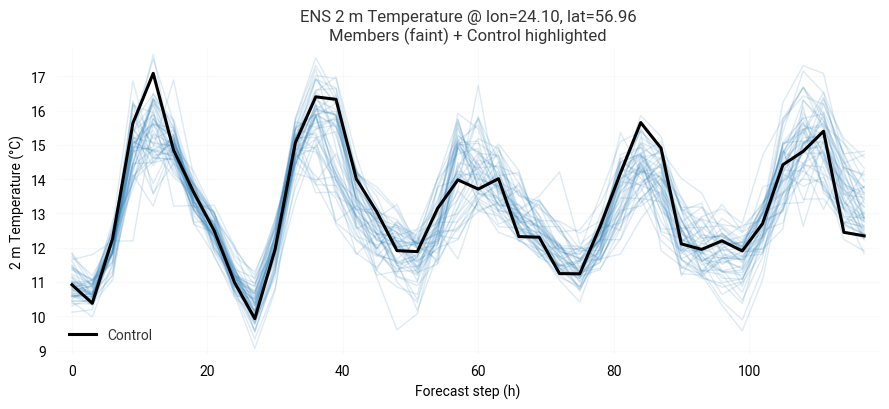

In [24]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Location (change to taste)
# lon, lat = 2.35, 48.86  # Paris example
# lon, lat = 7.09, 50.73  # Bonn example
lon, lat = 24.10, 56.96  # Riga example
# lon, lat = 0.97, 51.44  # Reading example
# lon, lat = 11.34, 44.49  # Bologna example



# ---- Perturbed members ----
xa_pf = ens_pf.sel(shortName="2t").to_xarray()  # expect dims: step, latitude, longitude, number (order can vary)
da_pf = xa_pf[list(xa_pf.data_vars)[0]] if isinstance(xa_pf, xr.Dataset) else xa_pf

# nearest grid point; ensure (step, number) order for plotting
pt_pf = da_pf.sel(longitude=lon, latitude=lat, method="nearest")
if "step" in pt_pf.dims and "number" in pt_pf.dims:
    pt_pf = pt_pf.transpose("step", "number")  # shape: (n_steps, n_members)

# X axis: hours (avoid scientific notation from timedeltas)
if "step" in pt_pf.coords:
    try:
        x = (pt_pf["step"] / np.timedelta64(1, "h")).values
    except Exception:
        x = pt_pf["step"].values
    x_label = "Forecast step (h)"
else:
    x = np.arange(pt_pf.shape[0])
    x_label = "Index"

vals_pf_c = pt_pf.values - 273.15   # °C, shape (n_steps, n_members)

# ---- Control member ----
xa_cf = ens_cf.sel(shortName="2t").to_xarray()
da_cf = xa_cf[list(xa_cf.data_vars)[0]] if isinstance(xa_cf, xr.Dataset) else xa_cf
pt_cf = da_cf.sel(longitude=lon, latitude=lat, method="nearest")
# align control to same x ordering if step exists
if "step" in pt_cf.coords and "step" in pt_pf.coords:
    pt_cf = pt_cf.sel(step=pt_pf["step"])

vals_cf_c = np.asarray(pt_cf) - 273.15  # °C, shape (n_steps,)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(9, 4.2))

# all members (Matplotlib will plot each column vs x when y is (N, M))
ax.plot(x, vals_pf_c, color="tab:blue", alpha=0.15, linewidth=1, label="_members")

# control highlighted
ax.plot(x, vals_cf_c, color="k", linewidth=2.2, label="Control")

ax.set_xlabel(x_label)
ax.set_ylabel("2 m Temperature (°C)")
ax.set_title(f"ENS 2 m Temperature @ lon={lon:.2f}, lat={lat:.2f}\nMembers (faint) + Control highlighted")
ax.grid(True, alpha=0.3)
ax.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()

### Vertical profile — retrieval (IFS-single, pressure levels)

To create a vertical profile we need to request data for multiple **pressure‑level fields**, in this case for a single **step 0** (instantaneous profile). We retrieve temperature (**`t`**), relative humidity (**`r`**), as well as wind (**`u`/`v`), optionally **specific humidity (`q`)**. 
We will use these parameters not only for plotting data, but also for computing some popular indices.

We Use `levtype='pl'` and set `levelist` (e.g., `1000/925/850/...`).

**Note:** You can change pressure levels or add more variables if you need additional diagnostics.


In [25]:
# HRES pressure-level profile (step=0) — T (K), RH (%), U/V (m/s)
from ecmwf.opendata import Client
import earthkit.data as ekd

# Standard pressure levels (hPa)
levels = [1000, 925, 850, 700, 500, 300, 250, 200, 150, 100, 50]

client = Client(source="ecmwf")
res = client.retrieve(
    model="ifs",
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=levels,
    step=0,                          # analysis time (forecast step 0)
    param=["t", "r", "u", "v"],      # temperature, relative humidity, wind components
    # date=fc_date, time=int(fc_time),  # <- optional: uncomment to pin the run
    target="data/hres_pl_truv_step0.grib2",
)
print("HRES run used:", res.datetime, "| levels:", levels)

# Load for sounding
prof = ekd.from_source("file", "data/hres_pl_truv_step0.grib2")

20250822000000-0h-oper-fc.grib2:   0%|          | 0.00/25.5M [00:00<?, ?B/s]

HRES run used: 2025-08-22 00:00:00 | levels: [1000, 925, 850, 700, 500, 300, 250, 200, 150, 100, 50]


### Vertical profile (Skew-T/Log-P) — IFS-single, parcels & diagnostics

**What we plot:** A Skew-T/Log-P sounding at a chosen lon/lat using **IFS-single** pressure-level fields on the 0.25° open-data grid.  
We draw **environmental T/Td**, add **parcel paths** (**SFC**, **MU**, **ML**), overlay **wind barbs by pressure**, and print key diagnostics:
**CAPE/CIN**, **0–6 km bulk shear**, **LCL pressure/height**, and **θe**.

**Data behind the plot:** Retrieved once at **`levtype='pl'`** for step **0** (instantaneous). Typical parameters:
- Temperature **`t`**, Relative humidity **`r`** (dewpoint computed in the notebook), and winds **`u`/`v`**.
- Levels via **`levelist=1000/925/850/700/500/300/250/200/50`** (edit as needed).

**How this cell works:**
- Selects the **nearest model grid point** to your lon/lat, converts units (K→°C, Pa↔hPa), and **sorts pressure descending** (required for parcel and interpolation).
- Uses **MetPy** to compute **LCL**, parcel profiles (**SFC/MU/ML**), **CAPE/CIN**, **0–6 km shear**, and **θe**.
- Wind barbs are plotted along pressure; the map background is not used here to keep the profile clean.

**You can tweak:**
- **Location:** change lon/lat for the grid point.
- **Levels:** adjust `levelist` (add 925/700 etc.) to refine low/mid-level structure.
- **Parcels:** change MU/ML depth (e.g., 300 hPa / 100 hPa) or disable parcels you don’t need.
- **Style:** colours/linestyles for T/Td/parcel curves; barb density; axis limits.

**Notes:**
- Open-data products are on a **0.25° global grid (GRIB2)**; values are representative of the nearest model grid point.  
- Ensure pressure is **monotonic** (descending) before calling parcel/diagnostic functions.

**More info:**  
MetPy Soundings & CAPE/CIN: https://unidata.github.io/MetPy/latest/


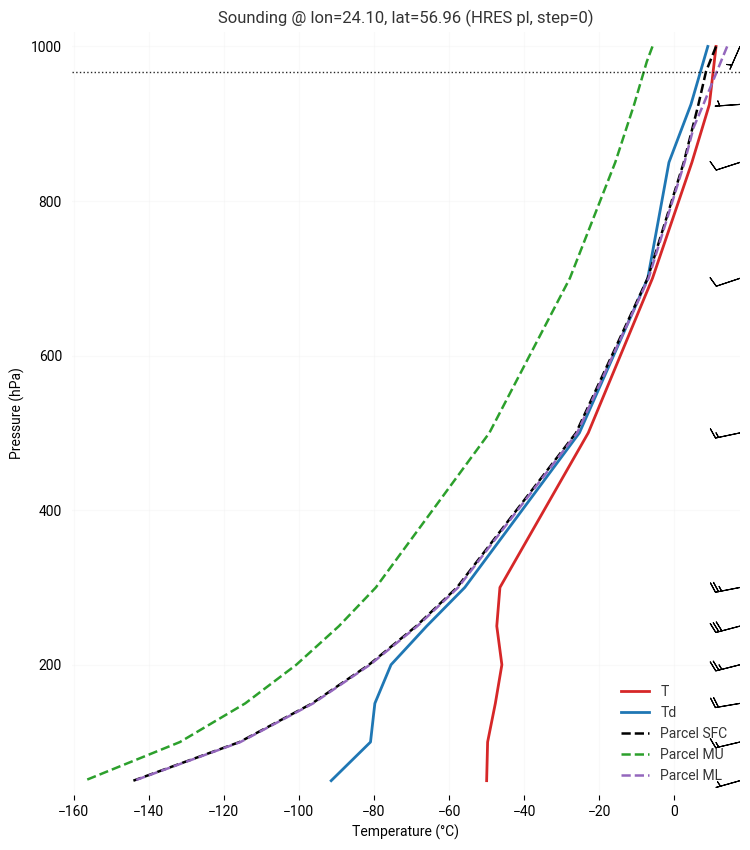

CAPE  SFC: 0 | CIN SFC: 0 | LCL SFC: 967 hPa (389 m std-atm)
CAPE   MU: 0  | CIN  MU: 0  (depth=300 hPa)
CAPE   ML: 0  | CIN  ML: 0  (depth=100 hPa)
0–6 km bulk shear: 12.2 m/s (23.6 kt)
θe surface: 304.2 K | θe ~850 hPa: 303.0 K


In [26]:
# Sounding: T & Td + SFC/MU/ML parcel curves, wind barbs, and diagnostics (CAPE/CIN, shear, LCL, θe)
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# MetPy
from metpy.units import units
from metpy.calc import (
    dewpoint_from_relative_humidity,
    lcl,
    parcel_profile_with_lcl,
    surface_based_cape_cin,
    most_unstable_cape_cin,
    mixed_layer_cape_cin,
    most_unstable_parcel,
    mixed_parcel,
    equivalent_potential_temperature,
    pressure_to_height_std,
)
from metpy.interpolate import interpolate_1d

# ---- location (change as needed)
# lon, lat = 2.35, 48.86  # Paris example
# lon, lat = 7.09, 50.73  # Bonn example
lon, lat = 24.10, 56.96  # Riga example
# lon, lat = 0.97, 51.44  # Reading example
# lon, lat = 11.34, 44.49  # Bologna example

# Helper: ensure xarray -> DataArray
def _as_da(xa):
    return xa[list(xa.data_vars)[0]] if isinstance(xa, xr.Dataset) else xa

# Read variables from your HRES profile file `prof` (created earlier with t,r,u,v on levtype=pl)
xa_t = prof.sel(shortName="t").to_xarray()   # K
xa_r = prof.sel(shortName="r").to_xarray()   # %
xa_u = prof.sel(shortName="u").to_xarray()   # m/s
xa_v = prof.sel(shortName="v").to_xarray()   # m/s

da_t, da_r, da_u, da_v = map(_as_da, (xa_t, xa_r, xa_u, xa_v))

def _pick(coordset, *cands):
    for c in cands:
        if c in coordset:
            return c
    return list(coordset)[-1]

lon_name = _pick(da_t.coords, "longitude", "lon")
lat_name = _pick(da_t.coords, "latitude", "lat")
lev_name = _pick(da_t.coords, "isobaricInhPa", "level", "pressure")

# Nearest-gridpoint profiles
pt_T  = da_t.sel({lon_name: lon, lat_name: lat}, method="nearest")  # K
pt_RH = da_r.sel({lon_name: lon, lat_name: lat}, method="nearest")  # %
pt_U  = da_u.sel({lon_name: lon, lat_name: lat}, method="nearest")  # m/s
pt_V  = da_v.sel({lon_name: lon, lat_name: lat}, method="nearest")  # m/s

# Sort surface -> top (descending pressure)
p_hpa = pt_T[lev_name].values.astype(float)
order = np.argsort(p_hpa)[::-1]
p   = (p_hpa[order] * units.hectopascal)
T   = (pt_T.values[order] * units.kelvin)
RHf = np.clip(pt_RH.values[order] / 100.0, 1e-3, 1.0)
U   = (pt_U.values[order] * units('m/s'))
V   = (pt_V.values[order] * units('m/s'))

# Dew point and θe along profile
Td     = dewpoint_from_relative_humidity(T, RHf)
thetae = equivalent_potential_temperature(p, T, Td)  # K

# ---------- Parcel profiles ----------
# SFC parcel (pass full profiles; MetPy uses index 0 as the parcel start)
p_prof_sfc, T_env_sfc, Td_env_sfc, Tparcel_sfc = parcel_profile_with_lcl(p, T, Td)

# MU/ML parcel starts (some MetPy versions return 4 values; slice first 3)
mu_tuple = most_unstable_parcel(p, T, Td, depth=300 * units.hPa)
mu_p, mu_T, mu_Td = mu_tuple[:3]
ml_tuple = mixed_parcel(p, T, Td, depth=100 * units.hPa)
ml_p, ml_T, ml_Td = ml_tuple[:3]

# Draw MU/ML parcel curves by substituting the start into the env profile, then re-running parcel_profile_with_lcl
T_env_mu,  Td_env_mu  = T.copy(),  Td.copy()
T_env_mu[0],  Td_env_mu[0]  = mu_T, mu_Td
p_prof_mu,  *_ , Tparcel_mu  = parcel_profile_with_lcl(p, T_env_mu, Td_env_mu)

T_env_ml,  Td_env_ml  = T.copy(),  Td.copy()
T_env_ml[0],  Td_env_ml[0]  = ml_T, ml_Td
p_prof_ml,  *_ , Tparcel_ml  = parcel_profile_with_lcl(p, T_env_ml, Td_env_ml)

# ---------- CAPE/CIN diagnostics ----------
cape_sfc, cin_sfc = surface_based_cape_cin(p, T, Td)
cape_mu,  cin_mu  = most_unstable_cape_cin(p, T, Td, depth=300 * units.hPa)
cape_ml,  cin_ml  = mixed_layer_cape_cin(p, T, Td, depth=100 * units.hPa)

# LCL (surface parcel)
lcl_p_sfc, _ = lcl(p[0], T[0], Td[0])
lcl_h = pressure_to_height_std(lcl_p_sfc)

# ---------- 0–6 km bulk shear ----------
H = pressure_to_height_std(p)  # meters (std atmosphere)
target_h = 6000 * units.m
u_6 = interpolate_1d(target_h, H, U).to('m/s')
v_6 = interpolate_1d(target_h, H, V).to('m/s')
u_0, v_0 = U[0].to('m/s'), V[0].to('m/s')
shear_0_6 = np.hypot((u_6 - u_0).m, (v_6 - v_0).m) * units('m/s')

# θe at surface and ~850 hPa
def nearest_idx(arr, val):
    return int(np.argmin(np.abs(arr - val)))
idx_850 = nearest_idx(p.to('hPa').m, 850.0)
thetae_sfc = thetae[0]
thetae_850 = thetae[idx_850]

# ---------- Prepare arrays for plotting ----------
P_env = p.to('hPa').m
T_c   = T.to('degC').m
Td_c  = Td.to('degC').m

P_sfc = p_prof_sfc.to('hPa').m
Tp_s  = Tparcel_sfc.to('degC').m

P_mu  = p_prof_mu.to('hPa').m
Tp_mu = Tparcel_mu.to('degC').m

P_ml  = p_prof_ml.to('hPa').m
Tp_ml = Tparcel_ml.to('degC').m

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(7.6, 8.6))

# Environment
ax.plot(T_c,  P_env, color="tab:red",   linewidth=2, label="T")
ax.plot(Td_c, P_env, color="tab:blue",  linewidth=2, label="Td")

# Parcels (each against its own pressure vector)
ax.plot(Tp_s,  P_sfc, color="k",         linestyle="--", linewidth=1.8, label="Parcel SFC")
ax.plot(Tp_mu, P_mu,  color="tab:green", linestyle="--", linewidth=1.8, label="Parcel MU")
ax.plot(Tp_ml, P_ml,  color="tab:purple",linestyle="--", linewidth=1.8, label="Parcel ML")

# LCL (surface)
ax.axhline(lcl_p_sfc.to('hPa').m, color="k", linestyle=":", linewidth=1, alpha=0.85)

ax.invert_yaxis()
ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel("Temperature (°C)")
ax.grid(True, alpha=0.3)
ax.legend(frameon=False, loc="best")
ax.set_title(f"Sounding @ lon={lon:.2f}, lat={lat:.2f} (HRES pl, step=0)")

# Wind barbs on shared pressure axis (use environmental pressure for y)
ax_barb = ax.twiny()
ax_barb.set_xlim(0, 1); ax_barb.set_xticks([]); ax_barb.set_xlabel("")
idx = np.arange(0, len(P_env), 1)  # thin for clarity
ax_barb.barbs(np.ones_like(idx), P_env[idx], U[idx].m, V[idx].m, length=6, linewidth=0.8)
ax_barb.invert_yaxis()

plt.tight_layout()
plt.show()

# ---- make shear scalars for clean printing
shear_ms = float(np.atleast_1d(shear_0_6.to('m/s').m).squeeze())
shear_kt = float(np.atleast_1d(shear_0_6.to('knots').m).squeeze())

# ---------- Print diagnostics ----------
def Jkg(x): return f"{x.to('J/kg').m:.0f}"
print(f"CAPE  SFC: {Jkg(cape_sfc)} | CIN SFC: {Jkg(cin_sfc)} | LCL SFC: {lcl_p_sfc.to('hPa').m:.0f} hPa "
      f"({pressure_to_height_std(lcl_p_sfc).to('meter').m:.0f} m std-atm)")
print(f"CAPE   MU: {Jkg(cape_mu)}  | CIN  MU: {Jkg(cin_mu)}  (depth=300 hPa)")
print(f"CAPE   ML: {Jkg(cape_ml)}  | CIN  ML: {Jkg(cin_ml)}  (depth=100 hPa)")
print(f"0–6 km bulk shear: {shear_ms:.1f} m/s ({shear_kt:.1f} kt)")
print(f"θe surface: {thetae[0].to('kelvin').m:.1f} K | θe ~850 hPa: {thetae[idx_850].to('kelvin').m:.1f} K")


## 4. Derived Parameters and Calculations (coming up, possibly also in Expert JN)
Example topics may include:
- compare datasets (aifs/ifs)
	- multiple sources (seasonal + deterministic)
		- c3s
		- s2s
		- combine 15day and 48 hr data (ACMAD use case)
- more derived params from ecmwf and combined data
	- EFI
	- others?
- Data reformatting (GeoTIFF, etc.)
- Open data notebooks combining with EUM data (MTG,Metop-SG)
- Use case notebooks for events in Africa
